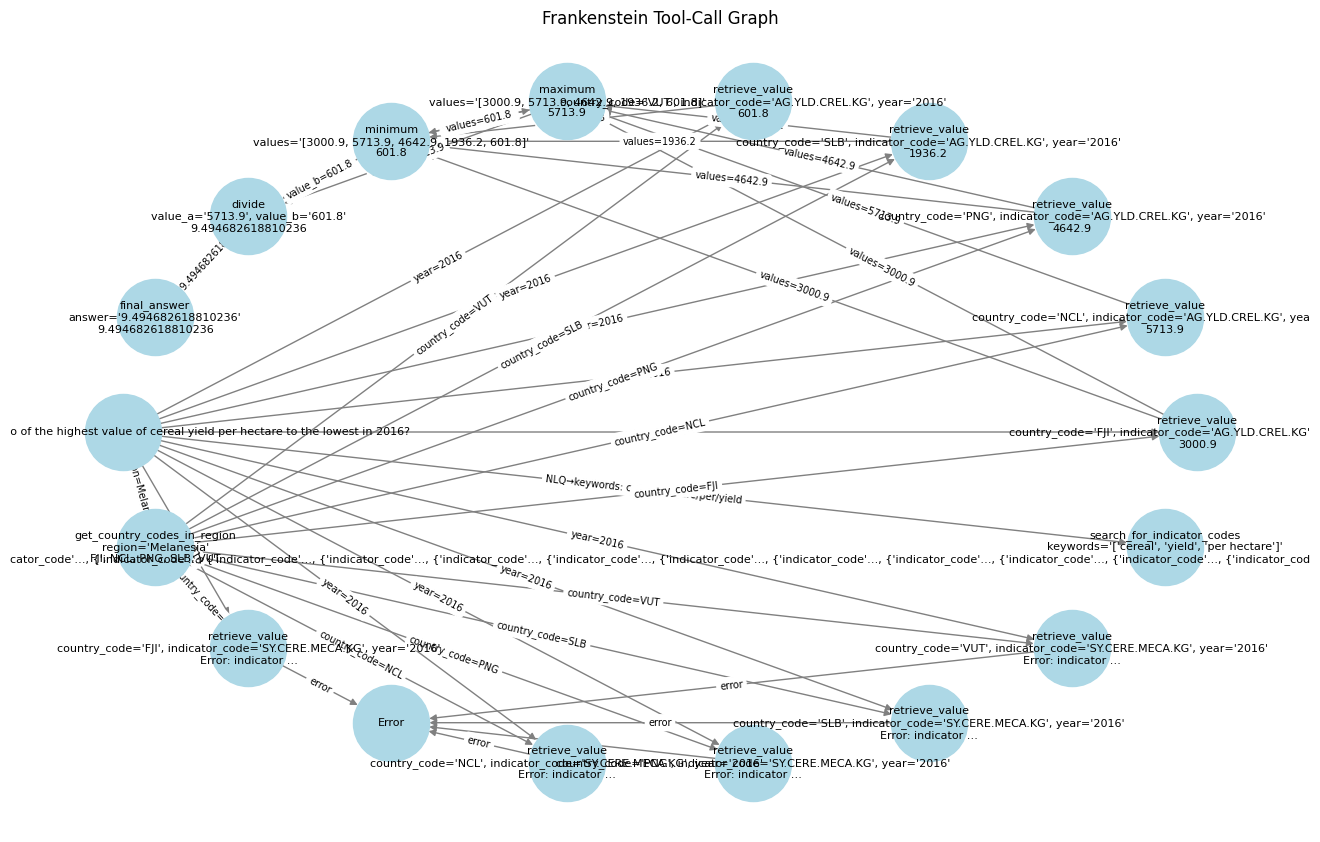

In [1]:
import logging
import os
import sys

import networkx as nx
import pandas as pd

# In Jupyter, __file__ is not defined, so use the current working directory
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from frankenstein.graph import FrankensteinGraph

# Suppress all logging from FrankensteinGraph and its dependencies
logging.getLogger().setLevel(logging.ERROR)

df = pd.read_json('../eval/runs/gpt-4o-mini_answerable-full.jsonl', orient='records', lines=True)

G = FrankensteinGraph(df.iloc[3])
# G.draw_pretty()
G.draw('shell')

In [2]:
for node_id, attrs in G.nodes(data=True):
    print(f'Node ID: {node_id}')
    print(f'  Label: {attrs.get("label")}')
    print(f'  Arguments: {attrs.get("args")}')
    print(f'  Result: {attrs.get("result")}')


Node ID: question_root
  Label: In Melanesia, what was the ratio of the highest value of cereal yield per hectare to the lowest in 2016?
  Arguments: None
  Result: None
Node ID: call_fB9YxA5fVR0VD0VAbQIKglWR
  Label: get_country_codes_in_region
  Arguments: {'region': 'Melanesia'}
  Result: ['FJI', 'NCL', 'PNG', 'SLB', 'VUT']
Node ID: call_tHusE1ofNw0Y1mMUz7HRUusc
  Label: retrieve_value
  Arguments: {'country_code': 'FJI', 'indicator_code': 'SY.CERE.MECA.KG', 'year': '2016'}
  Result: Error: indicator code 'SY.CERE.MECA.KG' is not valid. Ensure you have used the 'get_indicator_code_from_name' function to get the code from the indicator name.
Node ID: __error__
  Label: Error
  Arguments: None
  Result: None
Node ID: call_RBpioUGHWODkvze34E7apGoH
  Label: retrieve_value
  Arguments: {'country_code': 'NCL', 'indicator_code': 'SY.CERE.MECA.KG', 'year': '2016'}
  Result: Error: indicator code 'SY.CERE.MECA.KG' is not valid. Ensure you have used the 'get_indicator_code_from_name' function

In [3]:
def nodes_not_on_path(
    graph: FrankensteinGraph,
) -> list:
    """Return a list of nodes that are not on any path from the start node to the end node."""
    nodes = graph.nodes(data=True)

    end_node = next(n for n, attrs in nodes if attrs.get('label') == 'final_answer')

    unused_nodes = []
    for node_id, attrs in nodes:
        if not nx.has_path(graph, node_id, end_node):
            unused_nodes.append(node_id)

    return unused_nodes


# Example usage
unused_nodes = nodes_not_on_path(G)
for node_id in unused_nodes:
    print(f'Unused Node ID: {node_id}')
    attrs = G.nodes[node_id]
    print(f'  Label: {attrs.get("label")}')
    print(f'  Arguments: {attrs.get("args")}')
    print(f'  Result: {attrs.get("result")}')

Unused Node ID: call_tHusE1ofNw0Y1mMUz7HRUusc
  Label: retrieve_value
  Arguments: {'country_code': 'FJI', 'indicator_code': 'SY.CERE.MECA.KG', 'year': '2016'}
  Result: Error: indicator code 'SY.CERE.MECA.KG' is not valid. Ensure you have used the 'get_indicator_code_from_name' function to get the code from the indicator name.
Unused Node ID: __error__
  Label: Error
  Arguments: None
  Result: None
Unused Node ID: call_RBpioUGHWODkvze34E7apGoH
  Label: retrieve_value
  Arguments: {'country_code': 'NCL', 'indicator_code': 'SY.CERE.MECA.KG', 'year': '2016'}
  Result: Error: indicator code 'SY.CERE.MECA.KG' is not valid. Ensure you have used the 'get_indicator_code_from_name' function to get the code from the indicator name.
Unused Node ID: call_wXNw8F64WhF99BQrKQjqgruU
  Label: retrieve_value
  Arguments: {'country_code': 'PNG', 'indicator_code': 'SY.CERE.MECA.KG', 'year': '2016'}
  Result: Error: indicator code 'SY.CERE.MECA.KG' is not valid. Ensure you have used the 'get_indicator_co